# Birth death process with individual evolving birth rates

_Jonathan Lindström_

Consider a birth death process where each particle has it's own parameter $c$.
The birth rate of any individual is given by some function of $c$, such as $f(c) = 1 - c^2$ (letting it f(c) = 0 if it would be negative), or $f(c) = e^{-c^2}$. Generally I'd be most interested in some fairly smooth function with a single maximum somewhere.
So the birth rate is then

$\lambda_n = \sum_{i=1}^N f(c_i)$

A birth produces a new particle with parameter $c + X$ where $X$ is a random variable (probably normally dsitributed or similar is reasonable) and the $c$ is taken from the 'dividing'-particle (selected with probability proportional to $f(c)$).

The death is simply proportional to the number.

$\mu_n = N\mu$

Has something like this ever been studied? As you can see I'm very flexible on the details, the main idea is that the population will gradually adapt towards a maximum birth rate. Would a model like this be tractable, or is it hopelessly hard to analyze?

It could be an interesting model for modelling cells adapting slowly with a variety of factors that each contribute little or can happen gradually. Unlike mutation which cause a single very major change. There are mechanisms where something slow like this could be more appropriate. A change in treatment (or similar) could be represented as a change in the peak of $f(c)$ and if it is not too drastic the population might adapt.

I can't seem to find anything similar done already, but I might be missing something. So do you know if anything like this has been examined in some other context? Almost always, models seem to have one or a few discrete types.

Below is just a simple simulation. It is simple, although kinda slow, to simulate.

In [4]:
# Simulation example using a modified Gillespies algorithm
# Not a very good implementation

import numpy as np

class BP:
    def __init__(self, particles, sigma, death):
        # list of floating point numbers specifying 
        # internal parameter for each extant particle
        self.particles = particles
        self.t = 0
        self.sigma = sigma
        self.death = death
        self.optimum = 0
    
    def simulate(self, increment_time):
        end_time = self.t + increment_time
        while self.t < end_time:
            # calculate rates
            rates = np.array(self.particles)
            rates = 1 - (self.optimum - rates)**2
            rates[rates < 0] = 0
            
            # increment time dependent on total rate
            # total rate is sum of birth rates + sum of death rates
            total_rate = np.sum(rates) + self.particles.size*self.death
            if total_rate <= 0:
                # if we have no particles that can divide, end simulation
                t = end_time
                return
            self.t += np.random.exponential(1/total_rate)
            
            # select between birth and death
            if np.random.random() * total_rate < self.particles.size*self.death:
                select_particle = np.random.choice(self.particles.size)
                self.particles = np.delete(self.particles, select_particle)
            else:
            # normalize rates so that we can use it as probabilities to
            # select the dividing particle
                rates /= np.sum(rates)
                # select a particle and replace it with two new ones
                select_particle = np.random.choice(self.particles.size, 1, p=rates)
                select_lambda = self.particles[select_particle]
#                 self.particles[select_particle] = select_lambda + \
#                                                   np.random.normal(0, self.sigma)
#                 self.particles[select_particle] = select_lambda + \
#                                                   np.random.random()*self.sigma - \
#                                                   self.sigma / 2
                self.particles = np.append(self.particles, select_lambda + \
                                           np.random.normal(0, self.sigma))
            

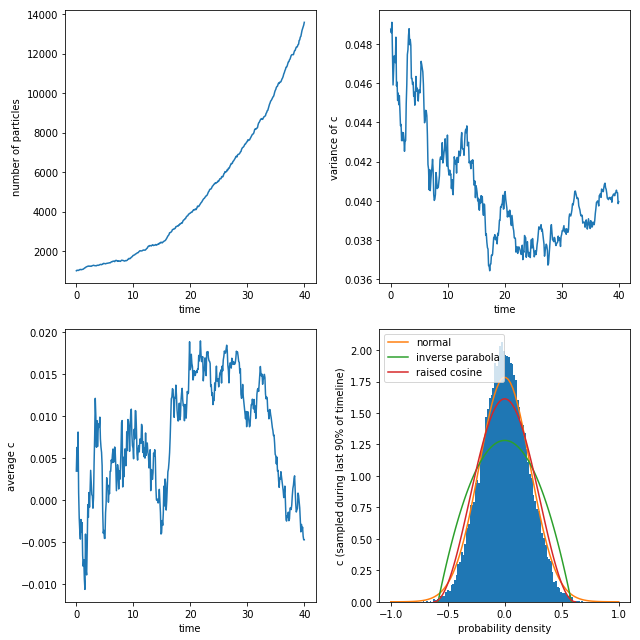

In [5]:
# sample process

import matplotlib.pyplot as plt

# simulate and save data every 0.1 timesteps
T_END = 40
bp = BP(np.random.normal(0, 0.22, 1000), 0.05, 0.9)
x = []
N = []
rate_mean = []
rate_variance = []
params = []
for i in range(T_END * 10):
    x.append(bp.t)
    N.append(bp.particles.size)
    rate_mean.append(np.mean(bp.particles))
    rate_variance.append(np.var(bp.particles))
    if i > T_END*9:
        params.extend(bp.particles)
    bp.simulate(0.1)
    
# plot results
fig, axs = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(9, 9)
axs[0][0].plot(x, N)
axs[1][0].plot(x, rate_mean)
axs[0][1].plot(x, rate_variance)
axs[1][1].hist(params, bins=100, density=True)
# normal distribution
a = 0.05
axs[1][1].plot(np.linspace(-1, 1, 100), 
               1/np.sqrt(2*np.pi*a)*np.exp(-np.linspace(-1, 1, 100)**2 / 2 / a), 
               label='normal')
# inverse parabola distribution
a = 1.71 # var = 3/(35a)
axs[1][1].plot(np.linspace(-1/a, 1/a, 100), 
               3*a/4*(1 - a**2*np.linspace(-1/a, 1/a, 100)**2), 
               label='inverse parabola')
# raised cosine distribution
a = 0.62
axs[1][1].plot(np.linspace(-a, a, 100), 
               1/2/a*(1 + np.cos(np.pi/a*np.linspace(-a, a, 100))), 
               label='raised cosine')

axs[0][0].set_xlabel('time')
axs[0][0].set_ylabel('number of particles')
axs[1][0].set_xlabel('time')
axs[1][0].set_ylabel('average c')
axs[0][1].set_xlabel('time')
axs[0][1].set_ylabel('variance of c')
axs[1][1].set_xlabel('probability density')
axs[1][1].set_ylabel('c (sampled during last 90% of timeline)')
axs[1][1].legend()

plt.tight_layout()
plt.show()

Above I started off with a $c$ distribution similar to what it seems to converge to anyway, and i provide some guesses for a distribution in the bottom right.

Change nomenclature such that

$\rho(c)$

is the rate function and 

$f_{c, t}(c)$ is the distribution of $c$ values at time $t$

I think a newborn particle has a $c$ according to

$E[c] = \int c \rho(c) f_{c, t}(c) dc$

Numerical testing below:

1.4706687681723913 1.4705882108173862
1.4737992823897132 1.472616605555676
1.474382333152495 1.474644999980088
1.4745380338972554 1.4766733940572963
1.4779048545804876 1.478701787750612
1.4808839007351005 1.4807301810196603
1.4827945906734974 1.4827585738200322
1.4842324568474916 1.484786966102907
1.487856849779612 1.4868153578146357
1.4898774393365481 1.488843748896295
1.491298522816981 1.490872139283199
1.4921301309780828 1.4929005289043678
1.4952126666995287 1.4949289176819558
1.4987344390533672 1.4969573055306247
1.499225663108091 1.498985692356871
1.5009061120421499 1.5010140780582915
1.5035497067633439 1.5030424625227927
1.5053561301610894 1.5050708456277302
1.5059079971414846 1.5070992272389825
1.5097573608948966 1.5091276072099484
1.511309974689328 1.5111559853804626
1.5127525404428626 1.513184361575626
1.5157026791163073 1.5152127356045408
1.516834593665862 1.517241107258955
1.5207243397999557 1.5192694763117887
1.520608893864843 1.5212978425155559
1.5218424562899864 1.5233262

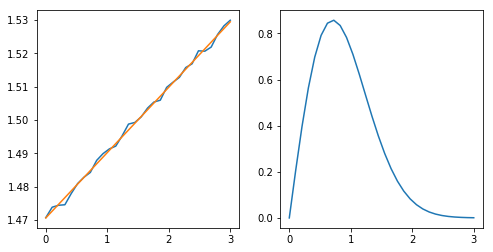

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps

offsets = np.linspace(0, 3, 30)
samplings = []
integrations = []
differentials = []

for offset in offsets:
    # distribution parameters
    MU = 1.5
    SIGMA = 0.1

    # random sampling
    N = 1000000
    SAMPLES = 10000

    def rate(c):
        return  np.exp(-(c - offset)**2)
#         return  np.maximum(1 - (c - 0.1*i)**2, 0)

    c = np.random.normal(MU, SIGMA, N)
    r = rate(c)
    r /= np.sum(r)
    new_c = np.random.choice(c, SAMPLES, p=r)

    # numerical integration

    RANGE = 4
    RESOLUTION = 10000

    x = np.linspace(-RANGE/2, RANGE/2, RESOLUTION)
    norm = simps(rate(x) * np.exp(-(x - MU)**2/(2*SIGMA**2)), x=x)
    y = x * 1/norm * rate(x) * np.exp(-(x - MU)**2/(2*SIGMA**2))

    samplings.append(np.mean(new_c))
    integrations.append(simps(y, x=x))
    print(samplings[-1], integrations[-1])
    
    # numerical differentiation
    
    DELTA = 0.0001
    
    differentials.append((rate(DELTA) - rate(-DELTA))/(2*DELTA))

fig, axs = plt.subplots(ncols=2)
fig.set_size_inches(8, 4)
axs[0].plot(offsets, samplings)
axs[0].plot(offsets, integrations)
axs[1].plot(offsets, differentials)
plt.show()

The suggested equation is accurate, but requires a normalization constant such that

$\int \rho(c) f_{c, t}(c) dc = 1$

The final expression becomes

$E[c] = \frac{1}{\int \rho(c) f_{c, t}(c) dc} \int c \rho(c) f_{c, t}(c) dc$

Curiously, with a gaussian rate function $E[c]$ is proportional to the distance between mean $c$ and the optimum.

What about the rate of change of the mean?

The growth rate at any point is as we said

$\sum_i \rho(c_i)$

Which, in this approximation becomes:

$N_t \int \rho(c) f_{c,t}(c) dc$

The average waiting time is the inverse of that, so we get:

$\frac{dE[f_{c, t}]}{dt} = N_t \int \rho(c) f_{c,t}(c) dc \cdot \frac{1}{N_t}E[c] 
                         = E[c] \int \rho(c) f_{c,t}(c) dc$
                         
or in full:

$\frac{dE[f_{c, t}]}{dt} = \frac{1}{\int \rho(c) f_{c, t}(c) dc} \int c \rho(c) f_{c, t}(c) dc \int \rho(c) f_{c,t}(c) = \int c \rho(c) f_{c, t}(c) dc$

(That simplified nicely)

How does this model fare? Simulation below:

In [7]:
# Simulation example using a modified Gillespies algorithm
# Not a very good implementation

import numpy as np

class BP:
    def __init__(self, particles, sigma, death):
        # list of floating point numbers specifying 
        # internal parameter for each extant particle
        self.particles = particles
        self.t = 0
        self.sigma = sigma
        self.death = death
        self.optimum = 0
    
    def simulate(self, increment_time):
        end_time = self.t + increment_time
        while self.t < end_time:
            # calculate rates
            rates = np.array(self.particles)
            rates = np.exp(-(rates - self.optimum)**2)
            rates[rates < 0] = 0
            
            # increment time dependent on total rate
            # total rate is sum of birth rates + sum of death rates
            total_rate = np.sum(rates) + self.particles.size*self.death
            if total_rate <= 0:
                # if we have no particles that can divide, end simulation
                t = end_time
                return
            self.t += np.random.exponential(1/total_rate)
            
            # select between birth and death
            if np.random.random() * total_rate < self.particles.size*self.death:
                select_particle = np.random.choice(self.particles.size)
                self.particles = np.delete(self.particles, select_particle)
            else:
            # normalize rates so that we can use it as probabilities to
            # select the dividing particle
                rates /= np.sum(rates)
                # select a particle and replace it with two new ones
                select_particle = np.random.choice(self.particles.size, 1, p=rates)
                select_lambda = self.particles[select_particle]
#                 self.particles[select_particle] = select_lambda + \
#                                                   np.random.random()*self.sigma - \
#                                                   self.sigma / 2
                self.particles = np.append(self.particles, select_lambda + \
                                           np.random.normal(0, self.sigma))
            

0.0005000050000500005 4.000040000400004e-05 0.006250062500625006


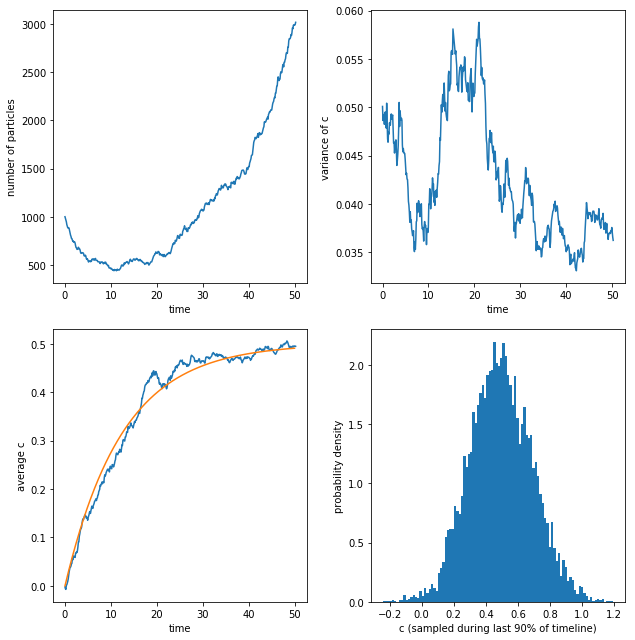

In [8]:
# sample process

import matplotlib.pyplot as plt
from scipy.integrate import simps

# simulate and save data every 0.1 timesteps
T_END = 50
OPTIMUM = 0.5
SIGMA = 0.22
MU = 0.0
bp = BP(np.random.normal(MU, SIGMA, 1000), 0.05, 0.9)
bp.optimum = OPTIMUM
x = []
N = []
rate_mean = []
rate_variance = []
params = []
for i in range(T_END * 10):
    x.append(bp.t)
    N.append(bp.particles.size)
    rate_mean.append(np.mean(bp.particles))
    rate_variance.append(np.var(bp.particles))
    if i > T_END*9:
        params.extend(bp.particles)
    bp.simulate(0.1)
    
RESOLUTION = 100000
    
# numerics
t = np.linspace(0, T_END, RESOLUTION)
E = [0.0]
SLOPE = 0.08
print(t[1] - t[0], (t[1] - t[0])*SLOPE, (t[1] - t[0])/SLOPE)
for __ in t[1:]:
    E.append(E[-1] + SLOPE*(OPTIMUM - E[-1])*(t[1] - t[0]))
E = np.array(E)
    
# plot results
fig, axs = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(9, 9)
axs[0][0].plot(x, N)
axs[1][0].plot(x, rate_mean)
axs[1][0].plot(t, E)
axs[0][1].plot(x, rate_variance)
axs[1][1].hist(params, bins=100, density=True)

axs[0][0].set_xlabel('time')
axs[0][0].set_ylabel('number of particles')
axs[1][0].set_xlabel('time')
axs[1][0].set_ylabel('average c')
axs[0][1].set_xlabel('time')
axs[0][1].set_ylabel('variance of c')
axs[1][1].set_xlabel('c (sampled during last 90% of timeline)')
axs[1][1].set_ylabel('probability density')

plt.tight_layout()
plt.show()

What about an asymmetric rate function? One nice option might be

$\rho(c) = ac^{\alpha}(1-c)^{\beta}$

Letting $\rho(c) = 0$ for $c \notin (0, 1)$

Or more generally with a location parameter $\mu$

Let $z = c + \frac{\alpha}{\alpha+\beta} - \mu$

$\rho(z) = ac^{\alpha}(1-z)^{\beta}$

defined on $-\frac{\alpha}{\alpha+\beta} - \mu < c < 1 - \frac{\alpha}{\alpha+\beta} - \mu$ or something like that. It has mode $\mu$, and the steepness of the function on either side of the mean can be controlled.


In [147]:
# Simulation example using a modified Gillespies algorithm
# Not a very good implementation

import numpy as np

class BP:
    def __init__(self, particles, factor, alpha, beta, death):
        # list of floating point numbers specifying 
        # internal parameter for each extant particle
        self.particles = particles
        self.t = 0
        self.factor = factor
        self.alpha = alpha
        self.beta = beta
        self.death = death
        self.optimum = 0
    
    def simulate(self, increment_time):
        end_time = self.t + increment_time
        while self.t < end_time:
            # calculate rates
            rates = np.array(self.particles)
            rates = self.factor*rates**self.alpha*(1 - rates)**self.beta
            rates[self.particles < 0] = 0
            rates[self.particles > 1] = 0
            
            # increment time dependent on total rate
            # total rate is sum of birth rates + sum of death rates
            total_rate = np.sum(rates) + self.particles.size*self.death
            if total_rate <= 0:
                # if we have no particles that can divide, end simulation
                t = end_time
                return
            self.t += np.random.exponential(1/total_rate)
            
            # select between birth and death
            if np.random.random() * total_rate < self.particles.size*self.death:
                select_particle = np.random.choice(self.particles.size)
                self.particles = np.delete(self.particles, select_particle)
            else:
            # normalize rates so that we can use it as probabilities to
            # select the dividing particle
                rates /= np.sum(rates)
                # select a particle and replace it with two new ones
                select_particle = np.random.choice(self.particles.size, 1, p=rates)
                select_lambda = self.particles[select_particle]
                self.particles = np.append(self.particles, select_lambda + \
                                           np.random.normal(0, 0.04))
            

0.015178320986275154
65.88344000000001


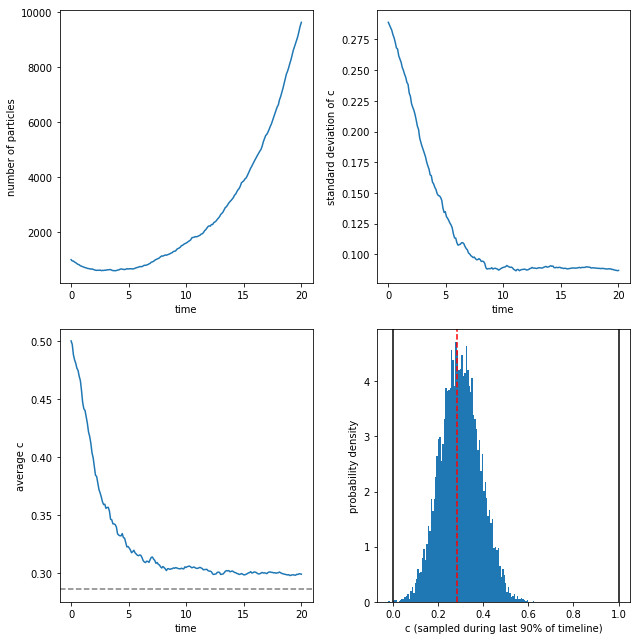

In [149]:
# sample process

import matplotlib.pyplot as plt
from scipy.integrate import simps

# simulate and save data every 0.1 timesteps
T_END = 20
OPTIMUM = 0.5
SIGMA = 0.1
MU = 0.5
ALPHA = 2
BETA = 5
FACTOR = 1/(ALPHA**ALPHA*BETA**BETA*(ALPHA + BETA)**(-ALPHA - BETA))
print(ALPHA**ALPHA*BETA**BETA*(ALPHA + BETA)**(-ALPHA - BETA))
print(1/(ALPHA**ALPHA*BETA**BETA*(ALPHA + BETA)**(-ALPHA - BETA)))
bp = BP(np.linspace(0, 1, 1000), FACTOR, ALPHA, BETA, 0.7)
bp.optimum = OPTIMUM
x = []
N = []
rate_mean = []
rate_variance = []
params = []
for i in range(T_END * 10):
    x.append(bp.t)
    N.append(bp.particles.size)
    rate_mean.append(np.mean(bp.particles))
    rate_variance.append(np.var(bp.particles))
    if i > T_END*9:
        params.extend(bp.particles)
    bp.simulate(0.1)
    
# plot results
fig, axs = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(9, 9)
axs[0][0].plot(x, N)
axs[1][0].plot(x, rate_mean)
axs[1][0].axhline(ALPHA/(ALPHA + BETA), linestyle='--', color='grey')
axs[0][1].plot(x, np.sqrt(rate_variance))
axs[1][1].hist(params, bins=100, density=True)
axs[1][1].axvline(0, color='k')
axs[1][1].axvline(1, color='k')
axs[1][1].axvline(ALPHA/(ALPHA + BETA), linestyle='--', color='red')

axs[0][0].set_xlabel('time')
axs[0][0].set_ylabel('number of particles')
axs[1][0].set_xlabel('time')
axs[1][0].set_ylabel('average c')
axs[0][1].set_xlabel('time')
axs[0][1].set_ylabel('standard deviation of c')
axs[1][1].set_xlabel('c (sampled during last 90% of timeline)')
axs[1][1].set_ylabel('probability density')

plt.tight_layout()
plt.show()

[0.28528529]


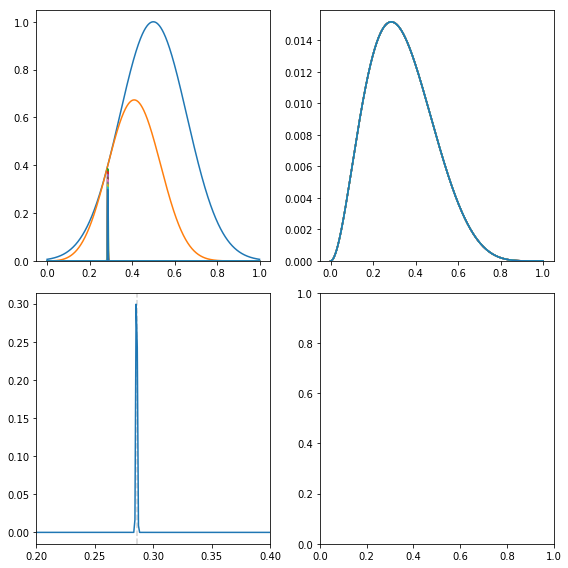

In [138]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps

ALPHA = 2
BETA = 5
ITERS = 100000
SKIP = 10000
FACTOR = 1/(ALPHA**ALPHA*BETA**BETA*(ALPHA + BETA)**(-ALPHA - BETA))

def rate(c):
    return  np.maximum(c**ALPHA*(1 - c)**BETA, 0)

distributions = []
rates = []
x = np.linspace(0, 1, 1000)
d = np.exp(-(x - 0.5)**2/0.05)
distributions.append(d[:])
rates.append(rate(x))

for i in range(ITERS - 1):
    d = d*rate(x)*FACTOR
    if i%SKIP != 0:
        continue
    distributions.append(d[:])
    rates.append(rate(x))

fig, axs = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(8, 8)
for y1, y2 in zip(distributions, rates):
    axs[0][0].plot(x, y1)
    axs[0][0].set_ylim(0, axs[0][0].get_ylim()[1])
    axs[0][1].plot(x, y2)
    axs[0][1].set_ylim(0, axs[0][1].get_ylim()[1])
    
axs[1][0].axvline(ALPHA/(ALPHA + BETA), linestyle='--', color='lightgrey')
axs[1][0].plot(x, distributions[-1])
axs[1][0].set_xlim(0.2, 0.4)

print(x[distributions[-1] == np.max(distributions[-1])])
    
# fig, axs = plt.subplots(nrows=ITERS, ncols=2)
# fig.set_size_inches(4, 2*ITERS)
# for i, y1, y2 in zip(range(ITERS), distributions, rates):
#     axs[i][0].plot(x, y1)
#     axs[i][0].set_ylim(0, axs[i][0].get_ylim()[1])
#     axs[i][1].plot(x, y2)
#     axs[i][1].set_ylim(0, axs[i][1].get_ylim()[1])
plt.tight_layout()
plt.show()

Let's make a stationary simulator that pairs death with birth and thus can be simulated for longer

In [26]:
# Simulation example using a modified Gillespies algorithm
# Not a very good implementation

import numpy as np

class SBP:
    def __init__(self, particles, factor, alpha, beta, perturb):
        # list of floating point numbers specifying 
        # internal parameter for each extant particle
        self.particles = particles
        self.t = 0
        self.factor = factor
        self.alpha = alpha
        self.beta = beta
        self.optimum = 0
        self.perturb = perturb
    
    def simulate(self, increment_time):
        end_time = self.t + increment_time
        while self.t < end_time:
            # calculate rates
            rates = np.array(self.particles)
            rates = self.factor*rates**self.alpha*(1 - rates)**self.beta
            rates[self.particles < 0] = 0
            rates[self.particles > 1] = 0
            
            # increment time dependent on total rate
            # total rate is sum of birth rates + sum of death rates
            total_rate = np.sum(rates)
            self.t += np.random.exponential(1/total_rate)
            
            # replicate random particle
            # normalize rates so that we can use it as probabilities to
            # select the dividing particle
            rates /= np.sum(rates)
            select_particle = np.random.choice(self.particles.size, 1, p=rates)
            select_lambda = self.particles[select_particle]
            self.particles = np.append(self.particles, select_lambda + \
                                       np.random.normal(0, self.perturb))
            
            # kill random particle
            select_particle = np.random.choice(self.particles.size)
            self.particles = np.delete(self.particles, select_particle)
            

2.6466569358398236e-07
3778351.423104578


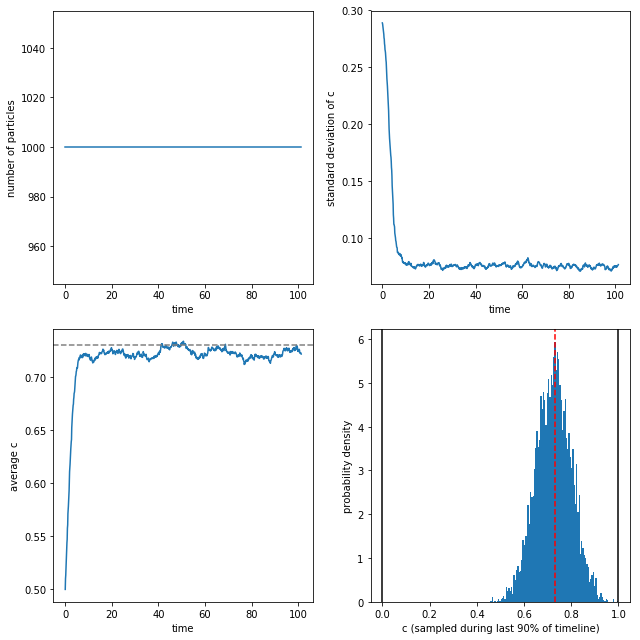

In [104]:
# sample process

import matplotlib.pyplot as plt
from scipy.integrate import simps

# simulate and save data every 0.1 timesteps
T_END = 100
OPTIMUM = 0.5
SIGMA = 0.1
MU = 0.5
ALPHA = 19
BETA = 7
PERTURB = 0.05
FACTOR = 1/(ALPHA**ALPHA*BETA**BETA*(ALPHA + BETA)**(-ALPHA - BETA))
print(ALPHA**ALPHA*BETA**BETA*(ALPHA + BETA)**(-ALPHA - BETA))
print(1/(ALPHA**ALPHA*BETA**BETA*(ALPHA + BETA)**(-ALPHA - BETA)))
bp = SBP(np.linspace(0, 1, 1000), FACTOR, ALPHA, BETA, PERTURB)
bp.optimum = OPTIMUM
x = []
N = []
rate_mean = []
rate_variance = []
params = []
for i in range(T_END * 10):
    x.append(bp.t)
    N.append(bp.particles.size)
    rate_mean.append(np.mean(bp.particles))
    rate_variance.append(np.var(bp.particles))
    if i > T_END*9:
        params.extend(bp.particles)
    bp.simulate(0.1)
    
# plot results
fig, axs = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(9, 9)
axs[0][0].plot(x, N)
axs[1][0].plot(x, rate_mean)
axs[1][0].axhline(ALPHA/(ALPHA + BETA), linestyle='--', color='grey')
axs[0][1].plot(x, np.sqrt(rate_variance))
axs[1][1].hist(params, bins=100, density=True)
axs[1][1].axvline(0, color='k')
axs[1][1].axvline(1, color='k')
axs[1][1].axvline(ALPHA/(ALPHA + BETA), linestyle='--', color='red')

axs[0][0].set_xlabel('time')
axs[0][0].set_ylabel('number of particles')
axs[1][0].set_xlabel('time')
axs[1][0].set_ylabel('average c')
axs[0][1].set_xlabel('time')
axs[0][1].set_ylabel('standard deviation of c')
axs[1][1].set_xlabel('c (sampled during last 90% of timeline)')
axs[1][1].set_ylabel('probability density')

plt.tight_layout()
plt.show()

[0.73073073]


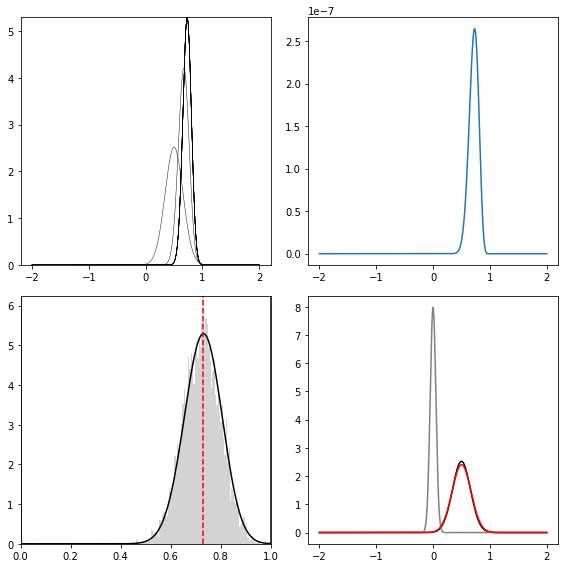

In [105]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps
import matplotlib.cm as cm

# ALPHA = 2
# BETA = 7
ITERS = 100
SKIP = 10
FACTOR = 1/(ALPHA**ALPHA*BETA**BETA*(ALPHA + BETA)**(-ALPHA - BETA))

def rate(c):
    tmp = np.maximum(c**ALPHA*(1 - c)**BETA, 0)
    tmp[c <= 0] = 0
    tmp[c >= 1] = 0
    return tmp

distributions = []
rates = []
x = np.linspace(-2, 2, 1000)
d = np.exp(-(x - 0.5)**2/0.05)
d /= simps(d, x=x)
distributions.append(d[:])
rates.append(rate(x))
noise = np.exp(-x**2/(2*0.05**2))
noise /= simps(noise, x=x)

for i in range(ITERS - 1):
    d = d*rate(x)*FACTOR
    d = np.convolve(d, noise, mode='same')
    d /= simps(d, x=x)
    
    if i%SKIP != 0:
        continue
    distributions.append(d[:])
    rates.append(rate(x))

fig, axs = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(8, 8)
for i, y1, y2 in zip(range(len(distributions)), distributions, rates):
    axs[0][0].plot(x, y1, color=cm.Greys(int((i + 100)/(len(distributions) + 100)*255)), linewidth=0.5)
    axs[0][0].set_ylim(0, max(axs[0][0].get_ylim()[1], max(y1)))
    
axs[0][1].plot(x, rates[0])
axs[1][0].axvline(ALPHA/(ALPHA + BETA), linestyle='--', color='lightgrey')
axs[1][0].plot(x, distributions[-1], color='k')
axs[1][0].set_xlim(0, 1)

axs[1][0].hist(params, bins=100, density=True, color='lightgrey')
axs[1][0].axvline(0, color='k')
axs[1][0].axvline(1, color='k')
axs[1][0].axvline(ALPHA/(ALPHA + BETA), linestyle='--', color='red')

y1 = distributions[0]
y2 = noise
y3 = np.convolve(y1, y2, mode='same')

y1 /= simps(y1, x=x)
y2 /= simps(y2, x=x)
y3 /= simps(y3, x=x)

axs[1][1].plot(x, y1, color='black')
axs[1][1].plot(x, y2, color='grey')
axs[1][1].plot(x, y3, color='red')


print(x[distributions[-1] == np.max(distributions[-1])])
plt.tight_layout()
plt.show()

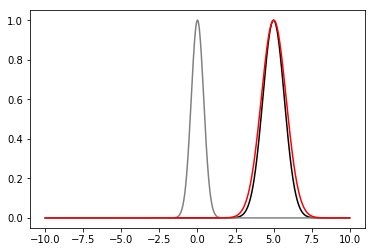

In [68]:
x1 = np.linspace(-10, 10, 1000)
# x2 = np.linspace(-1, 2, 0)
y1 = np.exp(-(x1 - 5)**2)
y2 = np.exp(-3*x1**2)
y3 = np.convolve(y1, y2, mode='same')

y1 /= max(y1)
y2 /= max(y2)
y3 /= max(y3)

fig, axs = plt.subplots()
axs.plot(x1, y1, color='black')
axs.plot(x1, y2, color='grey')
axs.plot(x1, y3, color='red')
plt.show()

/home/joliad/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  
/home/joliad/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1914: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


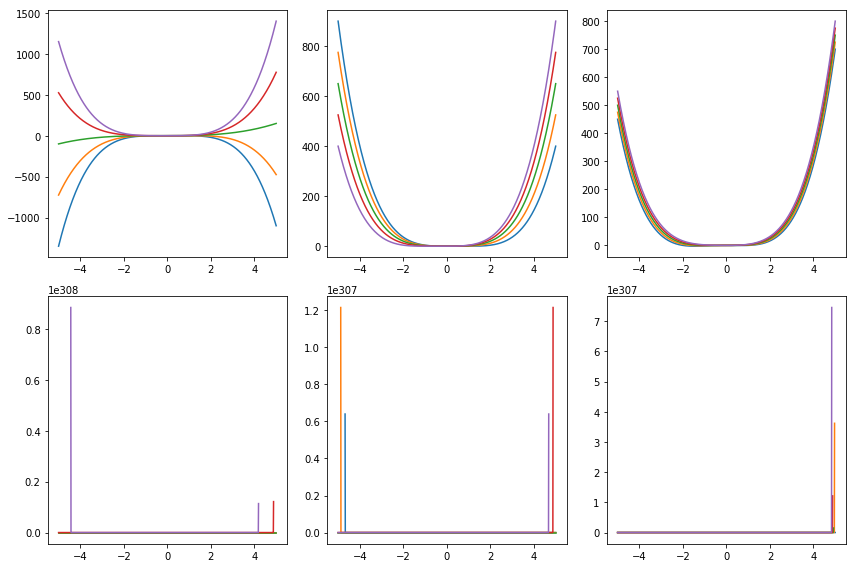

In [121]:
import numpy as np

# exp(7x-exp(2x)/2²+1)

def g(x, a, b, c):
    return a*x**4 + b*x**3 + c*x**2
def f(x, a, b, c):
    return np.exp(g(x, a, b, c))

x = np.linspace(-5, 5, 1000)
avals = np.linspace(-2, 2, 5)
bvals = np.linspace(-2, 2, 5)
cvals = np.linspace(-2, 2, 5)

fig, axs = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(12, 8)

b = c = 1
for i, a in enumerate(avals):
    axs[0][0].plot(x, g(x, a, b, c))
    axs[1][0].plot(x, f(x, a, b, c))
a = c = 1
for i, b in enumerate(bvals):
    axs[0][1].plot(x, g(x, a, b, c))
    axs[1][1].plot(x, f(x, a, b, c))
a = b = 1
for i, c in enumerate(cvals):
    axs[0][2].plot(x, g(x, a, b, c))
    axs[1][2].plot(x, f(x, a, b, c))

plt.tight_layout()
plt.show()

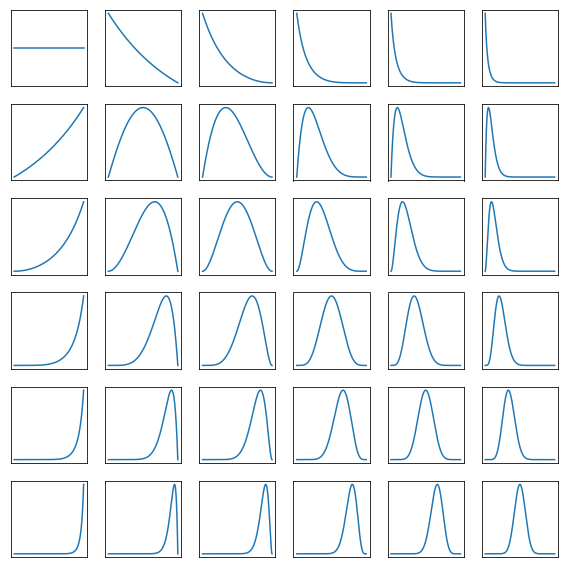

In [130]:
import numpy as np

def g(x, a, b):
    return a*x - np.exp(b*x)/b**2
def f(x, a, b):
    return np.exp(x**a * (1-x)**b)

x = np.linspace(0, 1, 1000)
avals = [0, 1, 2, 5, 10, 20]
bvals = [0, 1, 2, 5, 10, 20]

fig, axs = plt.subplots(nrows=len(avals), ncols=len(bvals))
fig.set_size_inches(8, 8)

for i, a in enumerate(avals):
    for j, b in enumerate(bvals):
        axs[i][j].plot(x, f(x, a, b))
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])

plt.tight_layout()
plt.show()

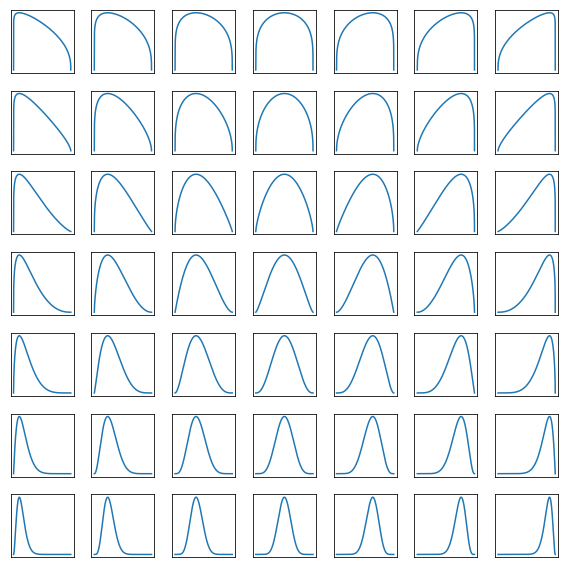

In [134]:
import numpy as np

def g(x, a, b):
    return a*x - np.exp(b*x)/b**2
def f(x, a, b):
    return np.exp(x**a * (1-x)**b)

x = np.linspace(0, 1, 1000)
sm = np.exp(np.linspace(-1, 3, 7))
center = np.linspace(0.1, 0.9, 7)

fig, axs = plt.subplots(nrows=len(sm), ncols=len(center))
fig.set_size_inches(8, 8)

for i, s in enumerate(sm):
    for j, c in enumerate(center):
        # c = a / (a + b)
        # s = a + b
        # c = a / s
        # a = s*c
        # b = s - a
        
        a = s*c
        b = s - a
        
        axs[i][j].plot(x, f(x, a, b))
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])

plt.tight_layout()
plt.show()